In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-08-17 13:27:24.332963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-17 13:27:24.332994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'scMNC-Motor'
modality_names = ['Gene Expression', 'Electrophysiology']
data1 = pd.read_csv("../data/scMNC/mouse_motor_cortex/data/geneExp_filtered.csv")
data2 = pd.read_csv("../data/scMNC/mouse_motor_cortex/data/efeature_filtered.csv")
sample_names1 = data1.columns[1:]
assert ((data1.shape[1] - 1) == data2.shape[0])
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)
meta = pd.read_excel("../data/scMNC/mouse_motor_cortex/data/motor_meta_data.xlsx")[['Cell', 'RNA family']]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, 0] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split()[0] for x in meta[meta_idx, 1]])

# Sampling
data_col_idx = np.random.choice(range(data1.shape[0]), 500, replace=False)
data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1, type2]
features = [None, None]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [x + x.min() for x in X]

In [5]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [6]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 3
batch_size = 250
pca_dim = [32, None]
dist_method = 'euclidean'

# ComManDo

In [7]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1286)
Dataset 1: (500, 29)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.2266 alpha:0.0990
epoch:[1000/2000] err:0.2638 alpha:0.1167
epoch:[1500/2000] err:0.2845 alpha:0.1284
epoch:[2000/2000] err:0.2935 alpha:0.1364
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.229388
epoch:[1000/2000]: loss:1.006338
epoch:[1500/2000]: loss:0.962885
epoch:[2000/2000]: loss:0.935043
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.35806949000107124
Correspondence: 13.268046726007015
Mapping: 30.924111749976873
Total: 44.55022796598496

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1286)
Dataset 1: (500, 29)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.203023
epoch:[1000/2000]: loss:0.969073
epoch:[1500/2000]: loss:0.917432
epoch:[2000/2

In [8]:
# Imputation
cm = ComManDo(**kwargs)
cm.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
cm_imputed = [cm.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (400, 1286)
Dataset 1: (400, 29)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.2522 alpha:0.1120
epoch:[1000/2000] err:0.2748 alpha:0.1244
epoch:[1500/2000] err:0.2843 alpha:0.1328
epoch:[2000/2000] err:0.2845 alpha:0.1388
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.209112
epoch:[1000/2000]: loss:1.000600
epoch:[1500/2000]: loss:0.941397
epoch:[2000/2000]: loss:0.933043
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.43526413396466523
Correspondence: 7.2215592169668525
Mapping: 17.949729134968948
Total: 25.606552485900465



# Comparison Methods

In [9]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
lma_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim, corr=half_priors)

# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
cca_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim, corr=half_priors)

In [10]:
# MMD-MA
from sklearn.metrics import pairwise_distances
mmd_ma_data, _, _ = mmd_combine(pairwise_distances(dataset[0]), pairwise_distances(dataset[1]), method='mmd_ma', p=reduced_dim)

# UnionCom
uc_data, _, _ = mmd_combine(*dataset, method='unioncom', output_dim=reduced_dim)

2022-08-17 13:33:16.893112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-17 13:33:16.893143: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-17 13:33:16.893155: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IR8CEDI): /proc/driver/nvidia/version does not exist
2022-08-17 13:33:16.893320: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


use random seed: 666
Shape of Raw data
Dataset 0: (500, 1286)
Dataset 1: (500, 29)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:1.1609 alpha:0.5054
epoch:[200/2000] err:0.1577 alpha:0.0687
epoch:[300/2000] err:0.2025 alpha:0.0883
epoch:[400/2000] err:0.2158 alpha:0.0942
epoch:[500/2000] err:0.2265 alpha:0.0990
epoch:[600/2000] err:0.2357 alpha:0.1032
epoch:[700/2000] err:0.2438 alpha:0.1070
epoch:[800/2000] err:0.2512 alpha:0.1105
epoch:[900/2000] err:0.2578 alpha:0.1137
epoch:[1000/2000] err:0.2637 alpha:0.1166
epoch:[1100/2000] err:0.2690 alpha:0.1194
epoch:[1200/2000] err:0.2737 alpha:0.1219
epoch:[1300/2000] err:0.2778 alpha:0.1242
epoch:[1400/2000] err:0.2814 alpha:0.1264
epoch:[1500/2000] err:0.2845 alpha:0.1284
epoch:[1600/2000] err:0.2871 alpha:0.1302
epoch:[1700/2000] err:0.2893 alpha:0.1319
epoch:[1800/2000] err:0.2911 alpha:0.1335
epoch:[1900/2000] err:0.2925 alpha:0.1350
epoch:[2000/2000] err:0.29

In [11]:
# NN
nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]

# Visualization

In [12]:
integrated_data = [cm_data, nlma_data, lma_data, cca_data, mmd_ma_data, uc_data]
integrated_names = ['JAMIE', 'Nonlinear\nManifold\nAlignment', 'Linear\nManifold\nAlignment', 'CCA', 'MMD-MA', 'Unioncom']
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', 'NN'][::-1]
colors = ['blue', 'red', 'green', 'm', 'yellow', 'teal']

sns.set(style='whitegrid')
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 18})

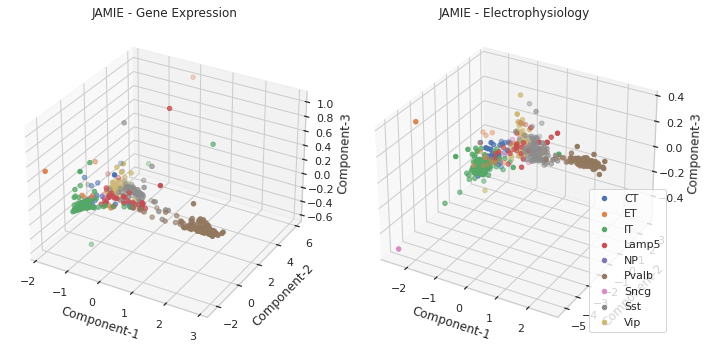

In [13]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png')

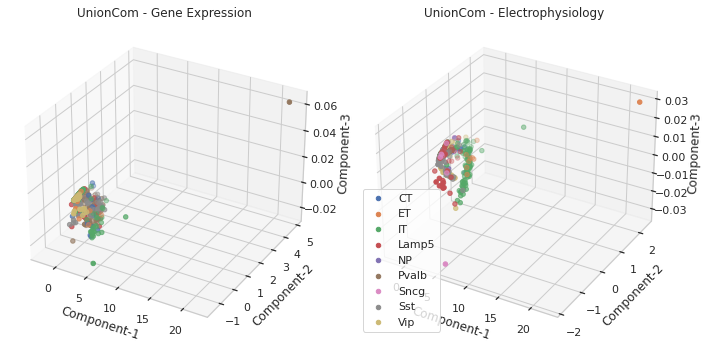

In [14]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(uc_data, labels, ['UnionCom - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-UnionCom.png')

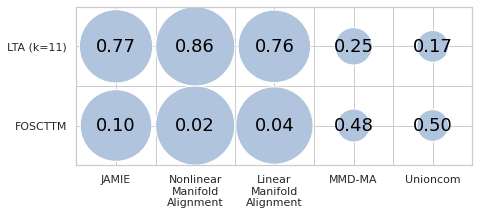

In [15]:
plt.figure(figsize=(7, 5))
plot_accuracy_table(integrated_data, labels, integrated_names, exclude=[3])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Acc.png')

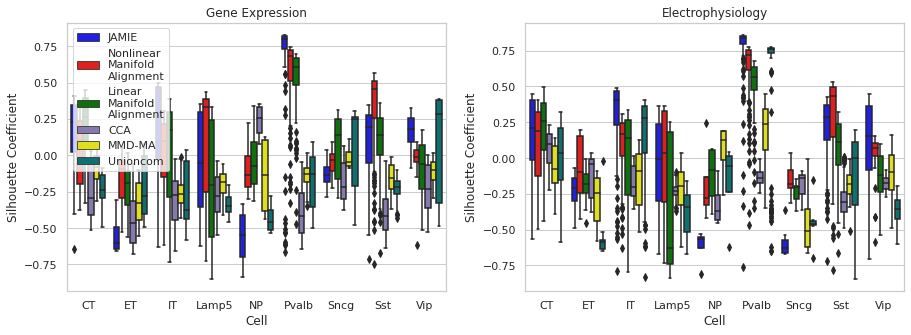

In [16]:
plt.figure(figsize=(13, 5))
plot_silhouette(integrated_data, labels, integrated_names, modality_names, colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png')

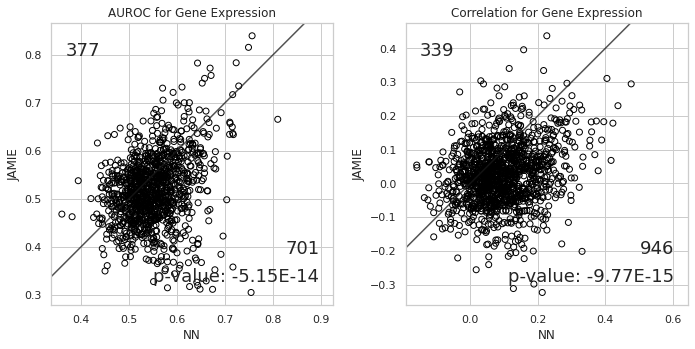

In [17]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png')

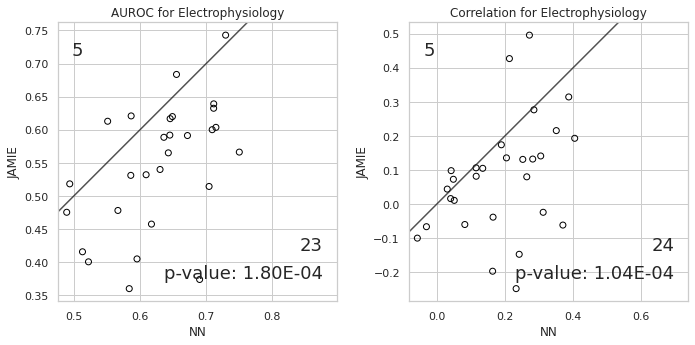

In [18]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png')

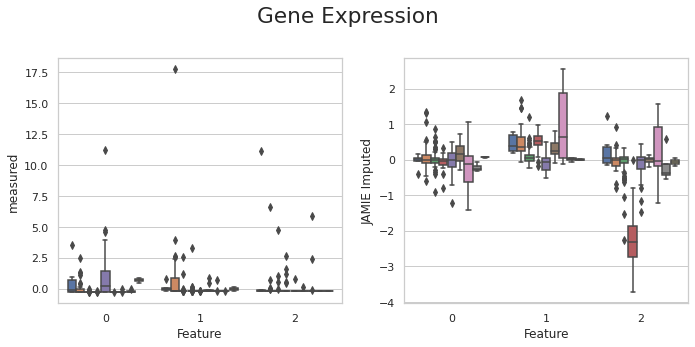

In [19]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], ['measured', 'JAMIE Imputed'], supert=modality_names[0], fnames=2*[features[0]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png')

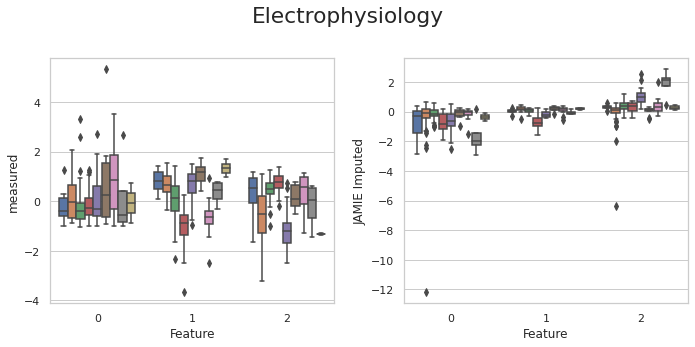

In [20]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], ['measured', 'JAMIE Imputed'], supert=modality_names[1], fnames=2*[features[1]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png')

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=axis, keepdims=True)


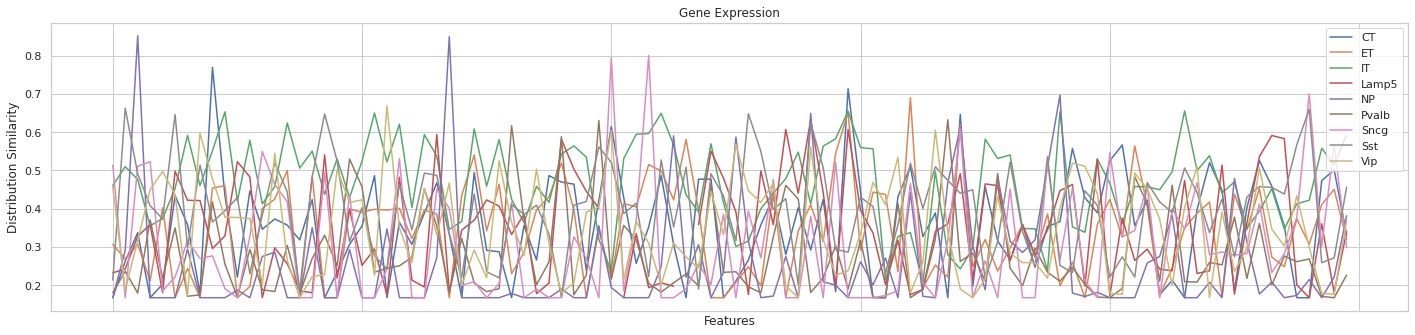

In [21]:
plt.figure(figsize=(20, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png')

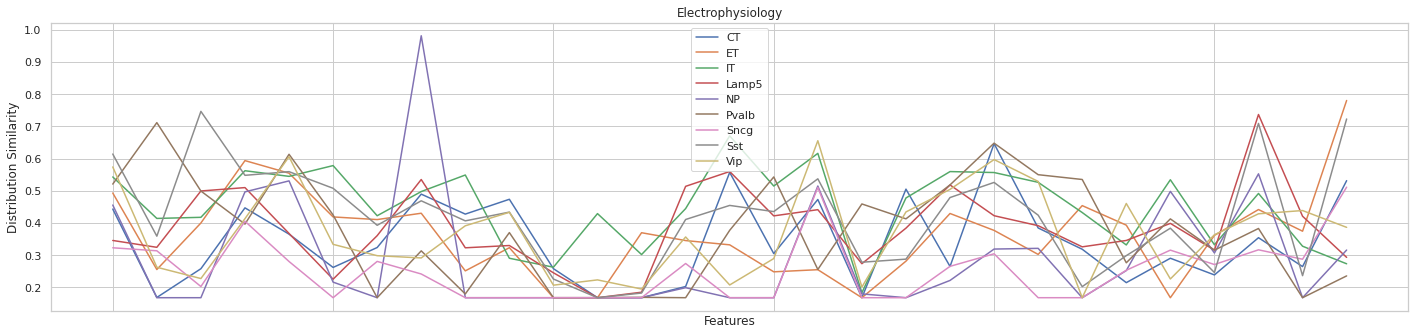

In [22]:
plt.figure(figsize=(20, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png')